In [126]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import yaml
import os
from skimage import morphology
from skimage.morphology import dilation, erosion, disk
from sklearn.cluster import KMeans

In [127]:
source_path = 'source/1.3'
config_file_path = os.path.join(source_path, 'config.yaml')

In [128]:

def load_specific_config(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        config = yaml.safe_load(file)

    # 提取特定配置项
    image_path = config.get('image', {}).get('path')
    candidate_points = config.get('candidate_points', [])
    zone_point = config.get('scan_zone', {}).get('center_point', [0, 0])
    zone_radius = config.get('scan_zone', {}).get('radius', 0)
    zone_theta = config.get('scan_zone', {}).get('angle', 0)
    valid_threshold = config.get('scan_zone', {}).get('valid_threshold', 0)
    step = config.get('scale', {}).get('step', 5)
    start_point = config.get('scale', {}).get('start', 0.0)
    end_point = config.get('scale', {}).get('end', 0.0)
    precision = config.get('scale', {}).get('precision', 0)
    unit = config.get('scale', {}).get('unit', '')

    return (
        image_path,
        candidate_points,
        zone_point,
        zone_radius,
        zone_theta,
        valid_threshold,
        step,
        start_point,
        end_point,
        precision,
        unit
    )

(
    image_path,
    candidate_point,
    zone_point,
    zone_radius,
    zone_theta,
    valid_threshold,
    step,
    START_POINT,
    END_POINT,
    PRESICISION,
    UNIT
) = load_specific_config(config_file_path)

# 打印提取的配置项以检查是否正确加载
print(f"Image Path: {image_path}")
print(f"Candidate Points: {candidate_point}\n")
print(f"Zone Point: {zone_point}")
print(f"Zone Radius: {zone_radius}")
print(f"Zone Theta: {zone_theta}")
print(f"Valid Threshold: {valid_threshold}")
print(f"step {step}")
print(f"Start Point: {START_POINT}\nEnd Point: {END_POINT}")
print(f"Precision: {PRESICISION}\nUnit: {UNIT}")

Image Path: source/1.3/template.jpg
Candidate Points: [[138, 578], [77, 441], [86, 292], [161, 167], [284, 88], [427, 72], [561, 121], [659, 224], [701, 360], [675, 502], [588, 620]]

Zone Point: [258, 274]
Zone Radius: 40
Zone Theta: 15
Valid Threshold: 70
step 5
Start Point: 0
End Point: 25
Precision: 2
Unit: MPa


In [129]:
img1 = cv2.imread(image_path)
# img2 = cv2.imread('source/1.1/img/tv20171228115547HWEU8S.jpg')
img2 = cv2.imread('source/1.3/img/65.jpg')
# img2 = cv2.imread('source/1.4/img/template.png')
# img2 = cv2.imread('source/2.1/img/77f19e2a3e11c69966e2b874e096c46.jpg')
# img2 = cv2.imread('source/2.1/img/bf2ad57729ebdc634305a087a1925d8.jpg')


In [130]:
# 展示图片
def show_img(image):
    # OpenCV 读取的图像是 BGR 格式，而 Matplotlib 显示的是 RGB 格式
    # 因此需要将图像从 BGR 转换为 RGB
    if image is None: print("Error: Unable to load image.")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 使用 Matplotlib 显示图像
        plt.figure(figsize=(6, 6))
        plt.imshow(image_rgb)
        plt.axis('off')  # 关闭坐标轴
        plt.show()

# 绘制点集在图片上 （reversed控制图片坐标系或真实坐标系）
def show_point(image, x_point, y_point, color=(0, 255, 255), coordinate_real=True):
    # 复制图像以避免修改原始图像
    image_temp = image.copy()

    # 检查是否是灰度图像并转换为BGR颜色空间
    if len(image_temp.shape) == 2:  # 如果图像只有高度和宽度，则为灰度图像
        image_temp = cv2.cvtColor(image_temp, cv2.COLOR_GRAY2BGR)

    # 绘制点
    for (x, y) in zip(x_point, y_point):
        if coordinate_real:
            # 翻转y坐标轴，因为某些坐标系原点在左下角
            cv2.circle(image_temp, (int(x), int(image.shape[0] - y)), 4, color, -1)
        else:
            cv2.circle(image_temp, (int(x), int(y)), 4, color, -1)
    show_img(image_temp)
def show_binary(array):
    gray_image = (array * 255).astype(np.uint8)  # 将True映射为255，False映射为0
    show_img(gray_image)

In [131]:
def my_fun(parameters, x_samples, y_samples):
    # Unpack parameters: two focus points and the target distance sum
    x_focus_1, y_focus_1, x_focus_2, y_focus_2, sum_of_target_distance = parameters

    # Calculate the actual distances from the points to the two foci
    distance_to_focus_1 = np.sqrt((x_samples - x_focus_1) ** 2 + (y_samples - y_focus_1) ** 2)
    distance_to_focus_2 = np.sqrt((x_samples - x_focus_2) ** 2 + (y_samples - y_focus_2) ** 2)

    # Return the difference between actual and target distances for each point
    return distance_to_focus_1 + distance_to_focus_2 - sum_of_target_distance

def fit_ellipse(x_samples, y_samples):

    # Compute the centroid of the samples
    centroid_x = np.mean(x_samples)
    centroid_y = np.mean(y_samples)

    # Find the point farthest from the centroid
    distances_from_centroid = np.sqrt((x_samples - centroid_x) ** 2 + (y_samples - centroid_y) ** 2)
    min_distance_index = np.argmin(distances_from_centroid)
    far_point_x = x_samples[min_distance_index]
    far_point_y = y_samples[min_distance_index]

    # Initial guess for the second focus
    x_focus_2_init = far_point_x
    y_focus_2_init = far_point_y

    x_focus_1_init = 2 * centroid_x - far_point_x
    y_focus_1_init = 2 * centroid_y - far_point_y


    # Estimate the sum of distances from any point on the ellipse to the foci
    sum_of_target_distance_init = 2 * distances_from_centroid[min_distance_index]

    # Optimize to fit the ellipse using initial guesses for the parameters
    initial_guess = np.array([x_focus_1_init, y_focus_1_init, x_focus_2_init, y_focus_2_init, sum_of_target_distance_init])
    res_optimized = least_squares(fun=my_fun, x0=initial_guess, args=(x_samples, y_samples))

    if res_optimized.success:
        # Unpack optimized parameters
        x1_res, y1_res, x2_res, y2_res, l2_res = res_optimized.x

        # Calculate the angle of the ellipse based on the foci
        alpha_res = np.arctan2(y2_res - y1_res, x2_res - x1_res)

        # Calculate the distance between the foci
        l_ab = np.sqrt((y2_res - y1_res) ** 2 + (x2_res - x1_res) ** 2)

        # Calculate semi-major and semi-minor axes
        a_res = l2_res / 2  # Semi-major axis length
        b_res = np.sqrt(a_res**2 - (l_ab / 2)**2)  # Semi-minor axis length

        return a_res, b_res, (x1_res+x2_res)/2, (y1_res+y2_res)/2, alpha_res
    else:
        print('Fail to fit ellipse')
        return None


# (x, y) rotate around (h,k) with alpha
def rotate(x, y, alpha):
    x_rot = x * np.cos(alpha) - y * np.sin(alpha)
    y_rot = x * np.sin(alpha) + y * np.cos(alpha)
    return x_rot, y_rot
def get_Point_in_ellipse(a, b, theta):
    return a * np.cos(theta) , b * np.sin(theta)

def Point_in_ellipse(h, k, a, b, alpha, theta):
    x0, y0 = np.cos(theta), np.sin(theta)
    x_real_rot, y_real_rot = rotate(x0, y0, -alpha)
    x_real_rot, y_real_rot = get_Point_in_ellipse(a, b, np.arctan2(y_real_rot, x_real_rot))
    x_res, y_res = rotate(x_real_rot, y_real_rot, alpha)
    return x_res + h, y_res + k

In [132]:
def SIFT4H(img1, img2, debug):

    # 初始化SIFT检测器
    sift = cv2.SIFT_create()
    # 使用SIFT找到关键点和描述符
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN 参数设计
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)   # 或传递一个空字典

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # 准备计算单应性矩阵的数据
    good_matches = []
    pts1 = []
    pts2 = []

    # 应用比例测试
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.float32(pts1).reshape(-1, 2)
    pts2 = np.float32(pts2).reshape(-1, 2)

    # 获取单应性矩阵
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

    # 绘制匹配结果
    draw_params = dict(matchColor=(0, 255, 0),  # 使用绿色绘制匹配项
                       singlePointColor=None,
                       matchesMask=mask.ravel().tolist(),  # 只绘制内部点
                       flags=2)


    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)

    if not debug: return H
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title('Matches')
    plt.show()

    return H

In [133]:
def save_cv_image_with_plt(cv_image, output_path):
    # 如果图像是彩色的，则将其从BGR转换为RGB
    if len(cv_image.shape) == 3:
        rgb_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    else:
        rgb_image = cv_image  # 灰度图像不需要转换

    # 创建一个新的图形，并关闭坐标轴
    plt.figure()
    plt.axis('off')  # 关闭坐标轴
    plt.gca().set_axis_off()  # 隐藏边框

    # 显示图像
    plt.imshow(rgb_image, cmap='gray' if len(cv_image.shape) == 2 else None)

    # 保存图像到文件，bbox_inches='tight' 和 pad_inches=0 用来去掉边缘空白
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()  # 关闭当前图形以释放内存

In [134]:
# 使用单应矩阵 对点进行转换
# 图像坐标系
def transform_point_with_H(x_point, y_point, H):
    point = np.array([x_point, y_point], dtype=np.float32).T
    projected_points = (cv2.perspectiveTransform(point.reshape(-1,1,2), H).reshape(-1,2).T)
    return projected_points[0], projected_points[1]


def warp_image_and_points_with_H(H, img2, x_point, y_point):
    # 获取img2的尺寸
    height, width = img2.shape[:2]

    # 定义img2四个角点的位置
    corners = np.float32([[0, 0], [0, height], [width, height], [width, 0]]).reshape(-1, 1, 2)

    # 使用perspectiveTransform来找到四个角点变换后的位置
    transformed_corners = cv2.perspectiveTransform(corners, H)

    # 找到变换后的最小外接矩形
    x_min = min(transformed_corners[:, 0, 0])
    y_min = min(transformed_corners[:, 0, 1])
    x_max = max(transformed_corners[:, 0, 0])
    y_max = max(transformed_corners[:, 0, 1])

    # 计算新图像的宽度和高度
    new_width = int(np.round(x_max - x_min))
    new_height = int(np.round(y_max - y_min))

    # 调整H矩阵，使得变换后的图像不被裁剪
    translation_matrix = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float32)
    adjusted_H = np.dot(translation_matrix, H)

    # 应用透视变换到图像
    warped_img2 = cv2.warpPerspective(img2, adjusted_H, (new_width, new_height))

    # 将输入的点转换为正确的格式，并应用相同的变换矩阵
    points = np.array([x_point, y_point], dtype=np.float32).T.reshape(-1, 1, 2)
    transformed_points = cv2.perspectiveTransform(points, translation_matrix).reshape(-1, 2).T
    # 返回变换后的图像和点集
    return warped_img2, transformed_points[0], transformed_points[1]


In [135]:
def mask_in_ellipse(img, a, b, x0, y0, alpha):

    # Generate meshgrid for efficient computation
    Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)

    # Compute rotated coordinates
    x_rot = (X - x0) * cos_alpha + (Y - y0) * sin_alpha
    y_rot = -(X - x0) * sin_alpha + (Y - y0) * cos_alpha

    # Compute the ellipse equation and create a mask
    ellipse_mask = ((x_rot ** 2) / (a ** 2)) + ((y_rot ** 2) / (b ** 2)) <= 1

    return ellipse_mask

def crop_with_mask(img, mask, crop=True):
    # Apply the mask to the image
    img_masked = img.copy()

    if img.ndim == 3:
        img_masked[~mask] = [0, 0, 0]
    else :
        img_masked[~mask] = 0

    if not crop: return img_masked

    # Find bounding box of the non-zero elements in the masked image
    rows = np.any(img_masked, axis=1)
    cols = np.any(img_masked, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    # Crop the image using the bounding box
    cropped_img = img_masked[ymin:ymax+1, xmin:xmax+1]

    # Calculate new center coordinates relative to the cropped image
    new_x0 = x0 - xmin
    new_y0 = y0 - ymin

    return cropped_img, new_x0, new_y0

In [136]:

def kmeans_binarization(gray_img):
    """
    对输入图像应用中值滤波去噪和K-means聚类进行二值化。
    返回:
        numpy.ndarray: 二值化后的灰度图像。
    """
    # 将图像重塑为二维数组，其中每一行都是一个像素
    pixel_vals = gray_img.reshape((-1, 1))

    # 转换为浮点数类型
    pixel_vals = np.float32(pixel_vals)

    # 执行K-means聚类
    kmeans = KMeans(n_clusters=2, random_state=0)  # 设置随机种子以获得可重复的结果
    labels = kmeans.fit_predict(pixel_vals)

    # 获取质心并排序，以确定哪个是背景，哪个是前景
    quantized = kmeans.cluster_centers_[labels]
    sorted_centroids = np.sort(kmeans.cluster_centers_, axis=0)

    # 创建二值图像
    threshold_value = sorted_centroids.mean()  # 取两个质心的中间值作为阈值
    binary_img = np.where(quantized < threshold_value, 255, 0).astype(np.uint8)

    # 将图像恢复到原始尺寸
    binary_img = binary_img.reshape(gray_img.shape)

    return binary_img

def enhance_contrast_clahe(gray, clip_limit=2.0, tile_grid_size=(8, 8)):
    # 创建CLAHE对象
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    # 应用CLAHE
    enhanced = clahe.apply(gray)
    return enhanced

In [137]:
def convert_to_color_and_draw_lines(gray_image):

    # 使用Canny边缘检测器找出边缘
    edges = gray_image.copy()

    # 使用HoughLinesP函数进行概率霍夫变换以检测线段
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=10, minLineLength=zone_radius*1.2, maxLineGap=10)

    # 将灰度图像转换为三通道彩色图像
    color_image = cv2.cvtColor(gray_image.copy(), cv2.COLOR_GRAY2BGR)

    # 如果有检测到线段，则在彩色图上绘制这些线段
    line_res = []

    if lines is None:
        print('Falied')
        exit(0)

    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(color_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 在彩色图上绘制检测到的线
        line_res.append( line[0] )
        # print( (x1, y1), (x2, y2) )
        # show_img(color_image)
    return color_image, line_res

In [138]:
def trans_coordinate(x, y, yshape):
    return x, yshape - y

In [139]:
def draw_segment(color_image, x1, y1, x2, y2, color = (0,0,255), real_coordinate = True):
    x1, y1, x2, y2, = int(x1), int(y1), int(x2), int(y2)
    if real_coordinate:
        x1, y1 = trans_coordinate(x1, y1, color_image.shape[1])
        x2, y2 = trans_coordinate(x2, y2, color_image.shape[1])
    cv2.line(color_image, (x1, y1), (x2, y2), color, thickness=2)
    return color_image

In [140]:
def cross(x1, y1, x2, y2):
    return x1 * y2 - x2 * y1

def dot(x1, y1, x2, y2):
    return x1 * x2 + y1 * y2


def point_in_zone(x0, y0, x, y, vec_x, vec_y):
    x,y,vec_x, vec_y = x - x0, y - y0, vec_x - x0, vec_y - y0
    return cross(x,y,vec_x, vec_y) >= 0 and dot(x,y,vec_x, vec_y) >= 0

def vectors_angle(ux, uy, vx, vy):
    # 计算每个向量与正X轴之间的角度（以弧度为单位）
    angle_u = np.arctan2(uy, ux)
    angle_v = np.arctan2(vy, vx)

    # 计算两个角度之间的差值，并调整到[-pi, pi]范围内
    angle_diff = angle_v - angle_u
    if angle_diff > np.pi:
        angle_diff -= 2 * np.pi
    elif angle_diff < -np.pi:
        angle_diff += 2 * np.pi

    # 将角度差转换为度数
    return np.degrees(abs(angle_diff))

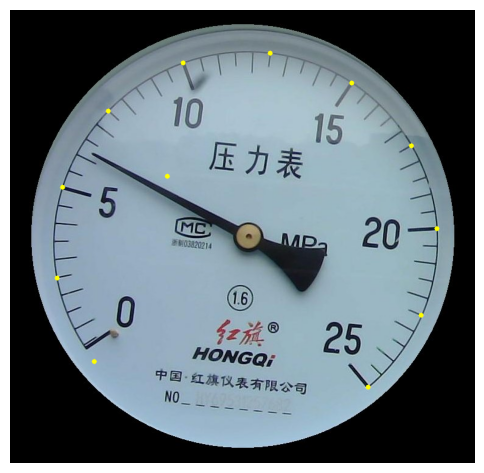

In [141]:
candidate_point = np.array(candidate_point)
candidate_point = np.vstack((candidate_point, zone_point))

x_samples = candidate_point.T[0]
y_samples = candidate_point.T[1]
show_point(img1, x_samples, y_samples, coordinate_real=False)

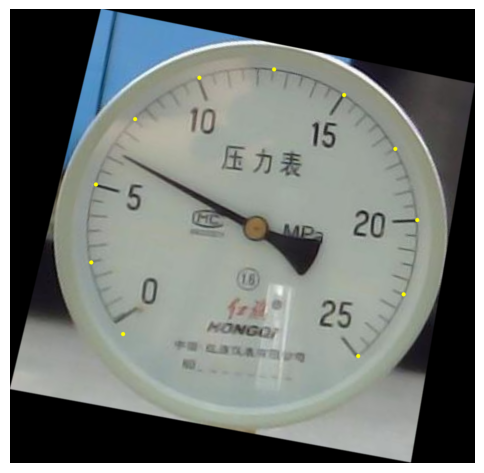

In [142]:
# 对待测图进行矫正 将标注点标注在新的图像上

H_img2_img1 = SIFT4H(img2, img1, False)
work_img, x_img_correct, y_img_correct = warp_image_and_points_with_H(H_img2_img1, img2, x_samples, y_samples)

zone_point_correct = (x_img_correct[-1], y_img_correct[-1])
x_img_correct = x_img_correct[:-1]
y_img_correct = y_img_correct[:-1]

show_point(work_img, x_img_correct, y_img_correct, coordinate_real=False)

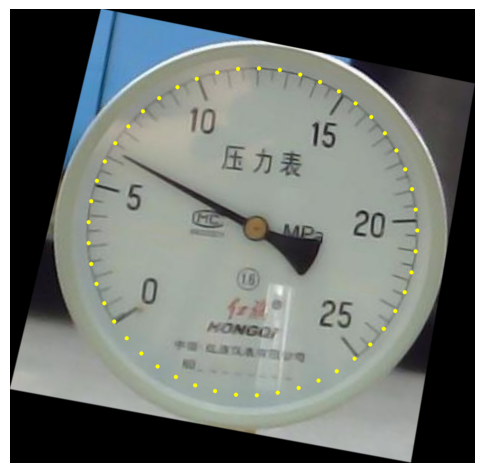

In [143]:
# 求解椭圆
a_res, b_res, x0, y0, alpha_res = fit_ellipse(x_img_correct, y_img_correct)

theta_res = np.linspace(0, 2*np.pi, 50)
x_res, y_res = Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_res)

# 预览 检查椭圆曲线拟合
show_point(work_img, x_res, y_res, coordinate_real=False)

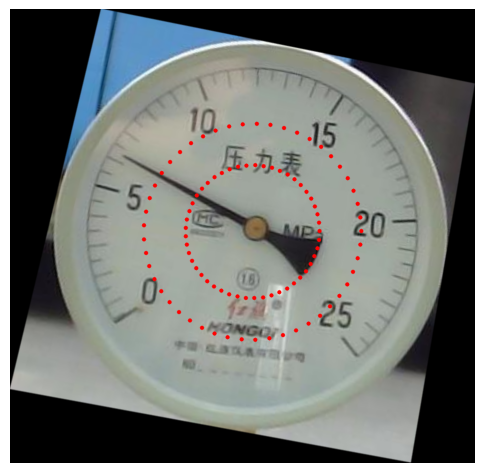

In [144]:
zone_point_x, zone_point_y = zone_point_correct[0], zone_point_correct[1]
zone_vec1 = np.array([zone_point_x, zone_point_y]) - np.array([x0,y0])
zone_vec2 = np.array([x_res[0], y_res[0]]) - np.array([x0,y0])
s = np.linalg.norm(zone_vec1)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
a_zone = a_res * s
b_zone = b_res * s

# 扫描区域可视化
s_l = (np.linalg.norm(zone_vec1)-zone_radius)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
s_r = (np.linalg.norm(zone_vec1)+zone_radius)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
x_zone_l, y_zone_l = Point_in_ellipse(x0, y0, a_res * s_l, b_res * s_l, alpha_res, theta_res)
x_zone_r, y_zone_r = Point_in_ellipse(x0, y0, a_res * s_r, b_res * s_r, alpha_res, theta_res)

show_point(work_img, np.concatenate((x_zone_l, x_zone_r)), np.concatenate((y_zone_l, y_zone_r)), (0, 0, 255), coordinate_real=False)

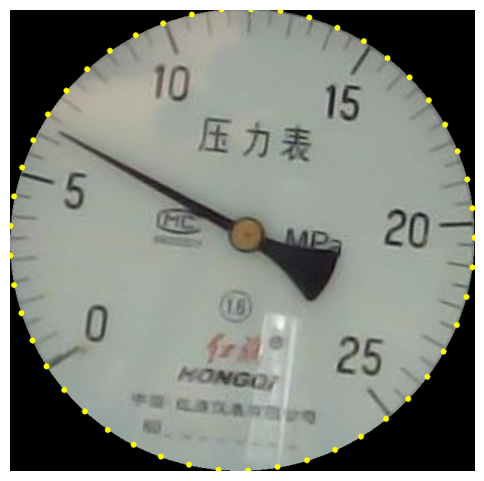

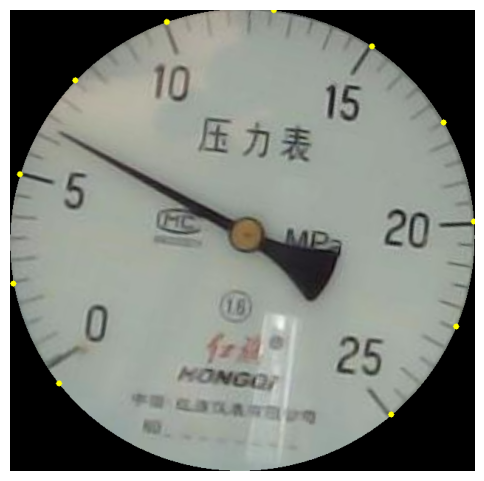

In [145]:
theta_img_correct = np.arctan2(y_img_correct - y0, x_img_correct - x0)
work_img_with_masked, x0, y0 = crop_with_mask(work_img, mask_in_ellipse(work_img, a_res , b_res, x0, y0, alpha_res))
theta_crop = np.linspace(0, 2*np.pi, 50)
x_crop, y_crop = Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_res)
# 预览 检查椭圆曲线拟合
show_point(work_img_with_masked, x_crop, y_crop, coordinate_real=False)

x_small_correct, y_small_correct = Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_img_correct)
show_point(work_img_with_masked, x_small_correct, y_small_correct, coordinate_real=False)

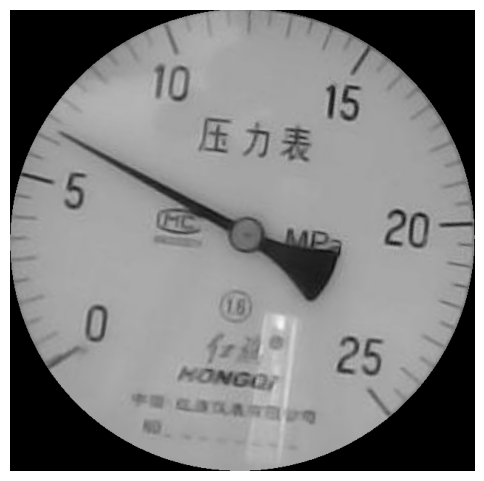

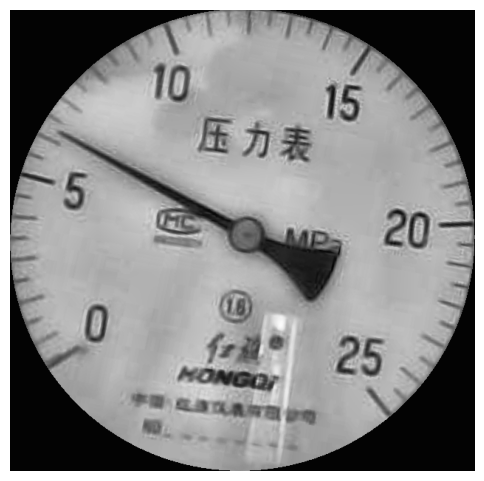

In [146]:
# 灰度图像增强对比度
gray_img = cv2.cvtColor(work_img_with_masked, cv2.COLOR_BGR2GRAY)
show_img(gray_img)
gray_img = enhance_contrast_clahe(gray_img)
show_img(gray_img)

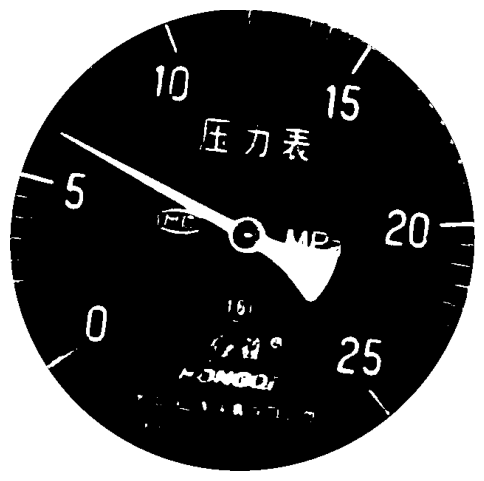

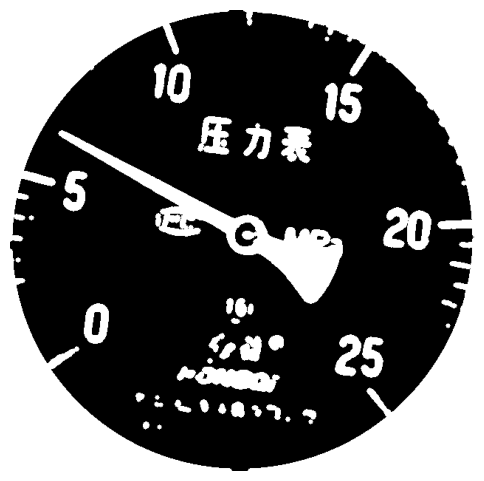

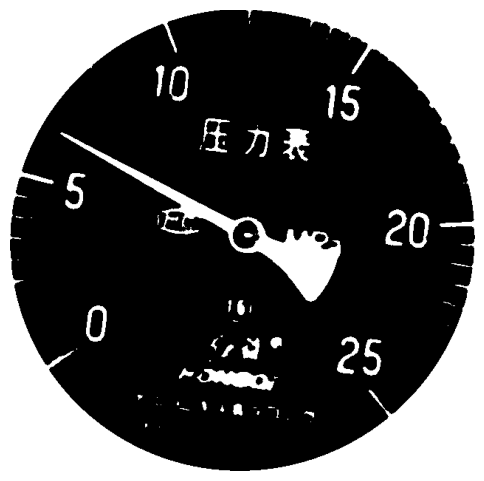

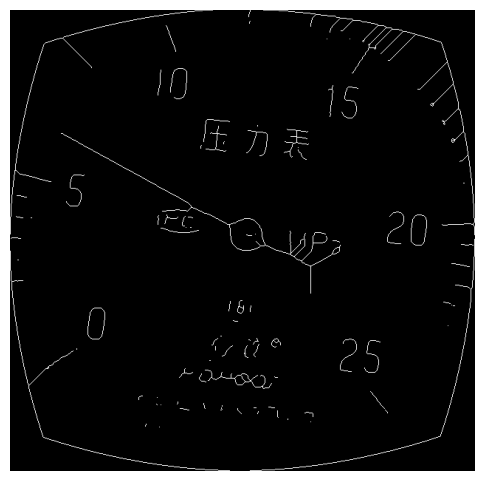

In [147]:
binary_img = kmeans_binarization(gray_img)
show_img(binary_img)

selem = disk(3)
# 膨胀操作：扩展前景区域
dilated_img = dilation(binary_img, selem)
show_img(dilated_img)
#
# 腐蚀操作：收缩前景区域
eroded_img = erosion(dilated_img, selem)
show_img(eroded_img)

# 骨架化处理
skeleton = morphology.skeletonize(binary_img)
skeleton_image = (skeleton * 255).astype(np.uint8)
show_img(skeleton_image)

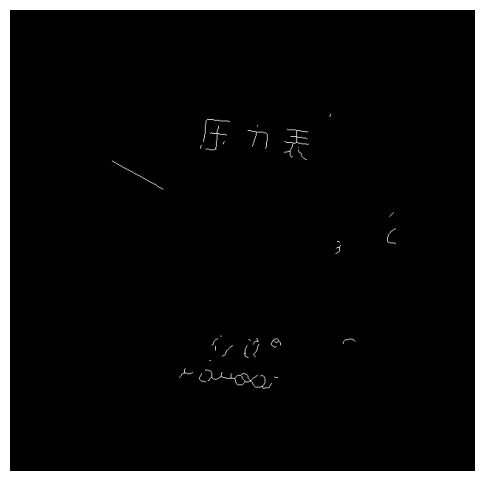

In [148]:
mask_inside = ~mask_in_ellipse(skeleton_image, a_res * s_l, b_res*s_l, x0, y0, alpha_res)
mask_outside = mask_in_ellipse(skeleton_image, a_res * s_r, b_res*s_r, x0, y0, alpha_res)
test_img = crop_with_mask(skeleton_image, mask_inside & mask_outside , crop=False)
show_img(test_img)

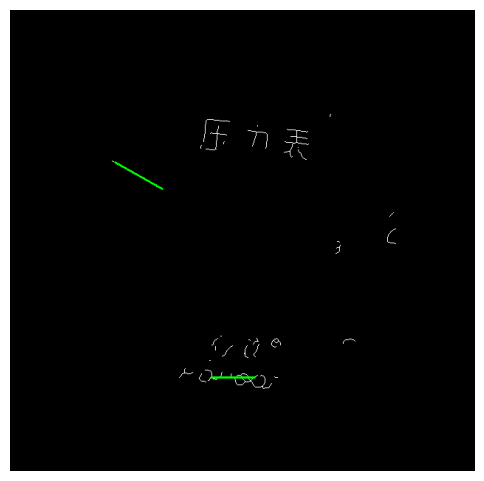

In [149]:
hough_img, res_line = convert_to_color_and_draw_lines(test_img)
show_img(hough_img)

In [150]:
x0, y0 = trans_coordinate(x0, y0, work_img_with_masked.shape[1])
# print((x0, y0))
for i in range(len(x_small_correct)):
    x_small_correct[i], y_small_correct[i] = trans_coordinate(x_small_correct[i], y_small_correct[i], work_img_with_masked.shape[1])
    # print((x_small_correct[i], y_small_correct[i]))
for i in range(len(res_line)):
    x1, y1, x2, y2 = res_line[i]
    x1, y1 = trans_coordinate(x1, y1, work_img_with_masked.shape[1])
    x2, y2 = trans_coordinate(x2, y2, work_img_with_masked.shape[1])
    res_line[i] = x1, y1, x2, y2

    # print(res_line[i], (x1, y1), (x2, y2))

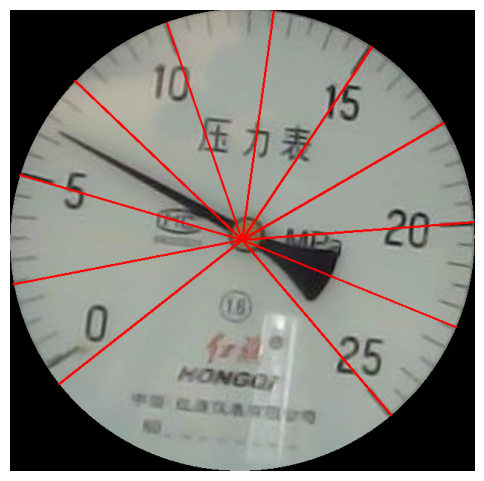

In [151]:
found_img = work_img_with_masked.copy()
for x, y in zip(x_small_correct, y_small_correct):
    found_img =  draw_segment(found_img, int(x0), int(y0), int(x), int(y), real_coordinate = True)

show_img(found_img)

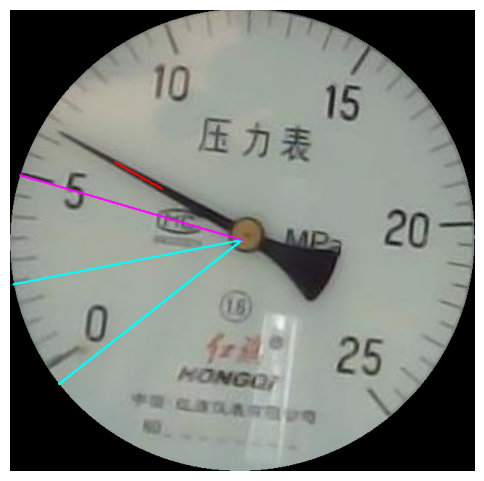

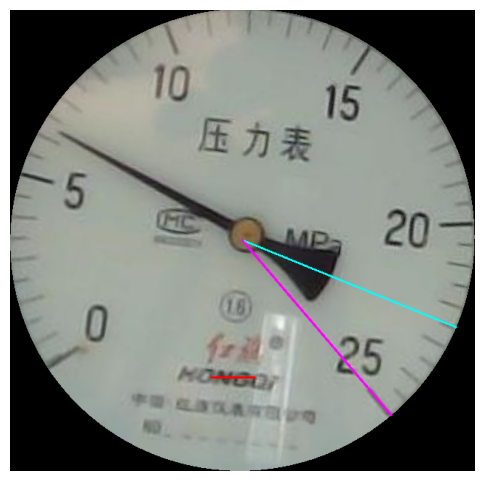

In [153]:
for line in res_line:

    x1, y1, x2, y2 = line

    related_x, related_y, related_res = None, None, None

    temp_found_img = work_img_with_masked.copy()
    for i, (x, y) in enumerate(zip(x_small_correct, y_small_correct)):
        if point_in_zone(x0, y0, x1, y1, x, y) and point_in_zone(x0, y0, x2, y2, x, y):
            related_x, related_y = x, y
            related_res = i

            draw_segment( temp_found_img, x0, y0, related_x, related_y, (255, 255, 0))

    if related_x is None:
        print(x1, y1, x2, y2, 'is illegal')
        continue


    draw_segment(temp_found_img, x1, y1, x2, y2)
    draw_segment(temp_found_img, related_x, related_y, x0, y0, (255, 0, 255))


    show_img(temp_found_img)

